In [10]:
low_memory=False
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 9.1 Introduction & Motivation

Much like supervised learning, unsupervised learning also has different applications and techniques.
In supervised learning, we had two main tasks to perform: regression and classification problems. In unsupervised learning, we have thus far explored cluster analysis. A second important task that can be performed in unsupervised learning is **dimensionality reduction**.

Dimensionality reduction does exactly what its name suggests: it reduces the number of dimensions (features) in our dataset while preserving the important information stored within them.

**Why is this important?**
- **Big Data challenges:** When working with large datasets, storage and computational costs become critical
- **Visualization:** High-dimensional data is impossible to visualize directly
- **Computational efficiency:** Fewer dimensions mean faster training and prediction
- **Noise reduction:** Removing irrelevant dimensions can improve model performance
- **Memory optimization:** Essential when working with limited computational resources

## 9.2 Problem Setting

We have already seen that in a dataset, the rows correspond to observations, and the columns correspond to variables (features). These variables are the dimensions of our dataset. Imagine we have a dataset with more than 100 variables. Whatever analysis we perform, the interpretation would be extremely challenging simply because it is very difficult to compare and understand relationships between 100 different factors simultaneously.

**The Curse of Dimensionality:**
- High-dimensional data becomes sparse and difficult to analyze
- Visualization becomes impossible beyond 3 dimensions
- Computational complexity grows exponentially
- Many algorithms perform poorly in high-dimensional spaces

As such, we're looking to reduce this number of variables intelligently. The process of reducing variables or dimensions is called **dimensionality reduction**, and we accomplish this by performing **feature analysis**. In other words, we analyze our features to reduce the total number of variables while preserving the most important information.

There are multiple approaches to this challenge, but the technique we will be exploring today is called **Principal Component Analysis (PCA)**.

**Key Concept:** PCA finds new variables (principal components) that are combinations of the original variables, ordered by how much variance they explain in the data.

The idea behind PCA is conceptually straightforward. For example, consider the following scatterplot:

**What you're about to see:** This example will demonstrate how two variables can be reduced to one while preserving most of the information.

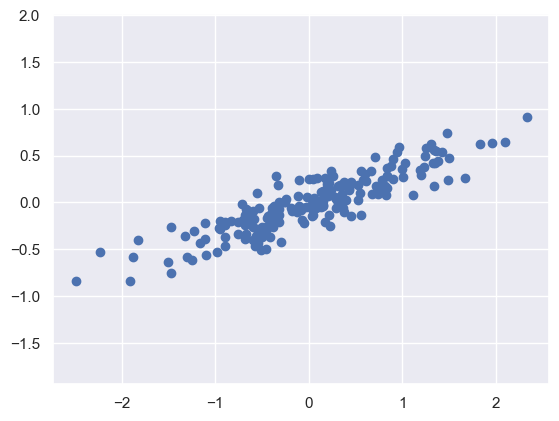

In [11]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

This dataset shows 2 variables plotted against each other. We saw in Chapter 2 that we can easily summarize the relationship between these two variables with a **Simple Linear Regression Model**. If we perform this analysis, we can estimate the value of one variable based on the value of the other variable. As such, we need only 1 variable to summarize all the information contained in the 2 variables represented above.

**Key Insight:** If two variables are highly correlated (like in the plot above), they contain redundant information. PCA identifies and eliminates this redundancy.

**This is exactly what PCA tries to accomplish!** 

PCA doesn't necessarily use Linear Regression, but employs different mathematical methods to summarize the information stored in several variables into fewer (but more informative) variables called **principal components**.

## 9.3 Model

### 9.3.1 Model

Remember the dataset we have used frequently in supervised classification: the handwritten digit recognition dataset. We'll use this dataset to illustrate the practical application of the PCA model.

**Important Note:** Remember that PCA is an **unsupervised** technique. In essence, we are looking for structure in our data without using the labels. However, in this example, we will occasionally compare our findings with the actual labels to evaluate how well PCA preserves meaningful information.

**Why this dataset is perfect for PCA:**
- High-dimensional: 64 features (pixels) per image
- Contains redundant information (many pixels are often blank or similar)
- Clear structure that should be preserved after dimensionality reduction
- Labels available for validation (though not used in PCA itself)

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In the Digit Recognition Dataset, you might wonder what all the dimensions represent. We looked at this at the beginning of the course, but let's clarify it again.

**Dataset Structure:**
- **Images and labels:** The dataset consists of pictures and their corresponding labels
- **Independent variables:** The pictures themselves are the features we want to find structure in
- **Pixel representation:** Each picture consists of 64 pixels, where each pixel has a value representing its intensity (clear/black/gray)
- **64 dimensions:** In other words, our dataset has 64 dimensions (one for each pixel)

**Logical reasoning for dimensionality reduction:**
Not all pixels are equally relevant for digit recognition:
- **Corner pixels:** Almost always blank and provide little information
- **Edge pixels:** Often contain less discriminative information
- **Central pixels:** Usually contain the most important digit features

**Question:** Why do we still include all pixels if many are not informative?

We can apply this logic to reduce dimensionality. For example, we could naively reduce the 64 dimensions to 8 by only keeping the first row of pixels:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-digits-pixel-components.png?raw=1)

**Naive approach limitation:** This might not be the most efficient approach. Simply selecting the first row of pixels is arbitrary and may miss important information in other parts of the image.

**PCA's intelligent approach:** Instead, we can use PCA and let the algorithm intelligently choose which combinations of pixels (components) best represent the digits:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-digits-pca-components.png?raw=1)

**Amazing result:** Our representation is still only 8 dimensions, but we haven't lost very much information! The PCA components capture the most important patterns across all pixels, not just arbitrary rows.

This demonstrates the power of PCA - it creates optimal combinations of original features to preserve maximum information with minimal dimensions.

### 9.3.2 Model Estimation

The first question we should ask ourselves when applying PCA is: **How many components should we retain?**

Luckily, there's a very handy tool to help us with this decision: the **explained variance ratio**. This is similar to the $R^2$ in Linear Regression, but it shows how much variance each component explains.

**Key Concepts:**
- **Explained variance ratio:** The proportion of total dataset variance explained by each component
- **Eigenvalue:** Another term for explained variance ratio of a component
- **Cumulative explained variance:** The total variance explained when combining multiple components

**Goal:** Find the optimal number of components that retain most information while achieving significant dimensionality reduction.

In [13]:
pca = PCA().fit(digits.data)
pca.explained_variance_ratio_

array([1.48905936e-01, 1.36187712e-01, 1.17945938e-01, 8.40997942e-02,
       5.78241466e-02, 4.91691032e-02, 4.31598701e-02, 3.66137258e-02,
       3.35324810e-02, 3.07880621e-02, 2.37234084e-02, 2.27269657e-02,
       1.82186331e-02, 1.77385494e-02, 1.46710109e-02, 1.40971560e-02,
       1.31858920e-02, 1.24813782e-02, 1.01771796e-02, 9.05617439e-03,
       8.89538461e-03, 7.97123157e-03, 7.67493255e-03, 7.22903569e-03,
       6.95888851e-03, 5.96081458e-03, 5.75614688e-03, 5.15157582e-03,
       4.89539777e-03, 4.28887968e-03, 3.73606048e-03, 3.53274223e-03,
       3.36683986e-03, 3.28029851e-03, 3.08320884e-03, 2.93778629e-03,
       2.56588609e-03, 2.27742397e-03, 2.22277922e-03, 2.11430393e-03,
       1.89909062e-03, 1.58652907e-03, 1.51159934e-03, 1.40578764e-03,
       1.16622290e-03, 1.07492521e-03, 9.64053065e-04, 7.74630271e-04,
       5.57211553e-04, 4.04330693e-04, 2.09916327e-04, 8.24797098e-05,
       5.25149980e-05, 5.05243719e-05, 3.29961363e-05, 1.24365445e-05,
      

**Understanding eigenvalues:**
Each eigenvalue does not represent the total explained variance on its own, but rather the **additional variance explained by that specific component**. 

**Important observations:**
- Eigenvalues are ordered from largest to smallest
- The first component explains the most variance
- Each additional component explains progressively less variance
- This decreasing pattern helps us identify where to "cut off" our components

**Mathematical insight:** The sum of all eigenvalues equals 1.0 (representing 100% of the total variance in the dataset).

##### Question 1: Use the data above to think of a way to figure out the best number of components. How many components would you ideally use in your analysis?

**Hints for solving this:**
- Plot the explained variance ratio to visualize the data
- Look for the "elbow" in the plot - where the slope significantly decreases
- The elbow indicates the point of diminishing returns
- Consider both information preservation and dimensionality reduction goals
- Think about what percentage of total variance you want to retain (e.g., 80%, 90%, 95%)

In [14]:
# Your code here


For now, we'll start with a simple example using just 2 components:

**Why start with 2 components?**
- Easy to visualize in a 2D scatter plot
- Demonstrates the basic concept clearly
- Shows how PCA transforms high-dimensional data to lower dimensions
- We can see if meaningful clusters emerge

In [15]:
pca = PCA(2)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Let's visualize what we have created with this transformation:

**What to expect:** We should see the 64-dimensional digit data projected onto just 2 dimensions, hopefully with some meaningful clustering patterns.

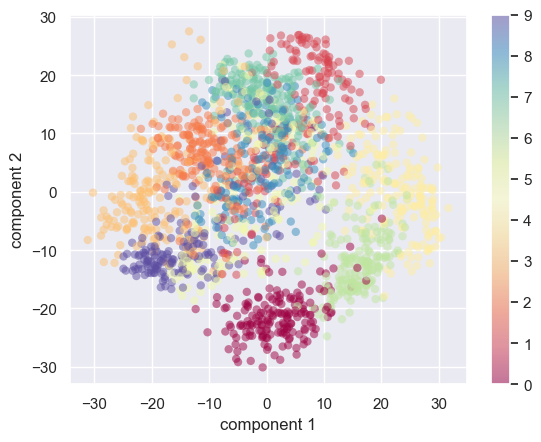

In [16]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.colormaps.get_cmap('Spectral')
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

##### Question 2: Create the PCA model using the optimal number of dimensions you found in Question 1. Create a train-test split and evaluate the model using Random Forest. Compare the results to a model using the original 64 dimensions.

**Steps to follow:**
1. Apply PCA with your chosen number of components to transform the digit data
2. Split the transformed data into training and testing sets
3. Train a Random Forest classifier on the PCA-transformed data
4. Train another Random Forest on the original 64-dimensional data
5. Compare accuracies to evaluate the trade-off between dimensionality reduction and performance

**What to analyze:**
- How much accuracy is lost (if any) due to dimensionality reduction?
- Is the trade-off worth it considering the reduction in features?
- Which approach would be better for large-scale applications?

In [17]:
# Your code here for PCA model


In [18]:
# Your code here for original model


## 9.4 Exercises

##### Question 1: See section 9.3.2
##### Question 2: See section 9.3.2

##### Question 3: PCA works by trying to retain as much variance as possible in our dataset. Can you explain why this makes sense intuitively?

**Your answer here:**

##### Question 4: PCA is often used for noise reduction. Can you explain why this would work?

**Your answer here:**